# COVID19 Data collection from John Hopkins (JH) by county
Two data files will be used for the collection of new cases and deaths for U.S. counties
* https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
* https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

Only pandas are required to run the script

In [1]:
import pandas as pd
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
# there are some counties without fips, but I am adding the one that should be
cases['FIPS'] = cases['FIPS'].fillna(cases['UID']-84000000)
# there are counties that are called Unassigned and Out of [state] for each state,
# that blows up in my face when I try to take it as a county because
# there are inconsistencies in the count of cases and deceased. let's eliminate!
cases = cases[cases['Admin2']!='Unassigned']
cases = cases[~cases['Admin2'].astype(str).str.startswith('Out of ')]
# There are weird fips, 60, 88888, 99999, 66, 69 and 78 (cruises and states) without Admin 2 column, fill with Province_State
cases['Admin2'] = cases['Admin2'].fillna(cases['Province_State'])
# Irrelevant columns
drop_col = ['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Admin2', 'Province_State']
rename_col = {'FIPS': 'fips'}
cases.rename(columns=rename_col, inplace=True)
new_cases = cases.drop(columns=drop_col).set_index('fips').T
new_cases.index = pd.to_datetime(new_cases.index)
new_cases.sort_index(inplace=True)
new_cases = new_cases.diff()
new_cases_raw = new_cases.copy()

deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
# there are some counties without fips, but I am adding the one that should be
deaths['FIPS'] = deaths['FIPS'].fillna(deaths['UID']-84000000)
deaths[deaths['FIPS'].isna()]['FIPS']
# there are counties that are called Unassigned and Out of [state] for each state,
# that blows up in my face when I try to take it as a county because
# there are inconsistencies in the count of cases and deceased. let's eliminate!
deaths = deaths[deaths['Admin2']!='Unassigned']
deaths = deaths[~deaths['Admin2'].astype(str).str.startswith('Out of ')]
# There are weird fips, 60, 88888, 99999, 66, 69 and 78 (cruises and states) without Admin 2 column, fill with Province State
deaths['Admin2'] = deaths['Admin2'].fillna(deaths['Province_State'])
# Irrelevant columns
deaths.rename(columns=rename_col, inplace=True)
deaths_drop = deaths.drop(columns=drop_col + ['Population']).set_index('fips').T
deaths_drop.index = pd.to_datetime(deaths_drop.index)
deaths_drop.sort_index(inplace=True)
new_deaths = deaths_drop.diff()
new_deaths_raw = new_deaths.copy()

In [4]:
cases

,UID,iso2,iso3,code3,fips,Admin2,Province_State,Country_Region,Lat,Long_,...,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5881,5910,5930,5970,5984,6002,6023,6024,6038,6050
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,18763,18824,18888,18960,18994,19051,19105,19136,19176,19267
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2008,2019,2024,2030,2036,2040,2042,2044,2055,2053
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2346,2362,2368,2377,2385,2393,2395,2397,2400,2399
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5920,5929,5937,5955,5953,5957,5961,5973,5987,5997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,...,3559,3561,3571,3586,3594,3594,3595,3595,3609,3614
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,3257,3266,3249,3256,3267,3267,3278,3278,3297,3298
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,1988,1994,1995,1992,1994,1994,1994,1994,2007,2016
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,870,870,871,872,873,873,873,873,874,874


We now have 4 dataframes:

* new_cases
* new_cases_raw
* new_deaths
* new_deaths_raw

Dataframes with raw suffix will not be touched until the end of the process and are saved because we will try to fix some inconsistencies in this script.

# Inconsistencies
The incosnsitence to be fixed here is the days with new negative cases and deaths. It is due to an update by eliminating cases in each of the counts. We will assume these are corrections and the most updated value is the "real" one until an update rewrites it.

In [2]:
# Routine to fix negative values
print('Routine to fix negative values')
i = 1
for fips in new_deaths:
    ndeaths = new_deaths[fips]
    if any(ndeaths < 0):
        while any(ndeaths < 0):
            rest_bmatrix = ndeaths<0 
            rest_matrix = ndeaths[rest_bmatrix] # These are the negative values to be fixed
            sumneg_matrix = ndeaths[rest_bmatrix] * -1
            rest_matrix.index = rest_matrix.index - pd.DateOffset(1) # it is necessary to eliminate them from the previous day
            ndeaths = ndeaths.add(sumneg_matrix, fill_value=0) # We add what we are going to subtract on the day of the problem
            ndeaths = ndeaths.add(rest_matrix, fill_value=0) # We subtract the cases from the previous day
        new_deaths[fips] = ndeaths
    print(f'new_deaths: {i}/{len(new_deaths.columns)}', end='\r')
    i += 1
print()
print('Done new_deaths')
i = 1
for fips in new_cases:
    ncase = new_cases[fips]
    if any(ncase < 0):
        while any(ncase < 0):
            rest_bmatrix = ncase<0 
            rest_matrix = ncase[rest_bmatrix] # These are the negative values to be fixed
            sumneg_matrix = ncase[rest_bmatrix] * -1
            rest_matrix.index = rest_matrix.index - pd.DateOffset(1) # it is necessary to eliminate them from the previous day
            ncase = ncase.add(sumneg_matrix, fill_value=0) # We add what we are going to subtract on the day of the problem
            ncase = ncase.add(rest_matrix, fill_value=0) # We subtract the cases from the previous day
        new_cases[fips] = ncase
    print(f'new_cases: {i}/{len(new_cases.columns)}', end='\r')
    i += 1
print()
print('Done new_cases')


Routine to fix negative values
new_deaths: 3236/3236
Done new_deaths
new_cases: 3236/3236
Done new_cases


In [3]:
new_cases

fips,1001.0,1003.0,1005.0,1007.0,1009.0,1011.0,1013.0,1015.0,1017.0,1019.0,...,56027.0,56029.0,56031.0,56033.0,56035.0,56037.0,56039.0,56041.0,56043.0,56045.0
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-13,18.0,57.0,4.0,8.0,4.0,2.0,6.0,52.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-14,21.0,54.0,2.0,2.0,4.0,3.0,4.0,71.0,3.0,2.0,...,0.0,8.0,1.0,5.0,0.0,1.0,11.0,0.0,0.0,0.0
2021-02-15,1.0,31.0,2.0,2.0,12.0,0.0,3.0,25.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-16,14.0,40.0,9.0,2.0,14.0,1.0,5.0,31.0,11.0,5.0,...,0.0,13.0,3.0,10.0,1.0,14.0,19.0,13.0,1.0,0.0


I love this layout by columns for each county but it is not usable because of DLab's historical format. let's transform it!

In [26]:
mergednewcases = pd.merge(new_cases.T, cases[['fips', 'Admin2', 'Province_State']],  left_index=True, right_on='fips')
mergednewcases.rename(columns={'Admin2': 'county'}, inplace=True)
mergednewcases.fillna(0, inplace=True)
mergednewcases_raw = pd.merge(new_cases_raw.T, cases[['fips', 'Admin2', 'Province_State']], left_index=True, right_on='fips')
mergednewcases_raw.rename(columns={'Admin2': 'county'}, inplace=True)
mergednewcases_raw.fillna(0, inplace=True)
std_new_cases = pd.melt(mergednewcases, id_vars=['fips', 'county', 'Province_State'], var_name='date', value_name='new_cases')
std_new_cases_raw = pd.melt(mergednewcases_raw, id_vars=['fips', 'county', 'Province_State'], var_name='date', value_name='new_cases')

mergednew_deaths = pd.merge(new_deaths.T, cases[['fips', 'Admin2', 'Province_State']], left_index=True, right_on='fips')
mergednew_deaths.rename(columns={'Admin2': 'county'}, inplace=True)
mergednew_deaths.fillna(0, inplace=True)
mergednew_deaths_raw = pd.merge(new_deaths_raw.T, cases[['fips', 'Admin2', 'Province_State']], left_index=True, right_on='fips')
mergednew_deaths_raw.rename(columns={'Admin2': 'county'}, inplace=True)
mergednew_deaths_raw.fillna(0, inplace=True)
std_new_deaths = pd.melt(mergednew_deaths, id_vars=['fips', 'county', 'Province_State'], var_name='date', value_name='new_death')
std_new_deaths_raw = pd.melt(mergednew_deaths_raw, id_vars=['fips', 'county', 'Province_State'], var_name='date', value_name='new_death')

std_new_cases.rename(columns={'Province_State': 'state'}, inplace=True)
std_new_cases_raw.rename(columns={'Province_State': 'state'}, inplace=True)
std_new_deaths.rename(columns={'Province_State': 'state'}, inplace=True)
std_new_deaths_raw.rename(columns={'Province_State': 'state'}, inplace=True)

std_new_cases = std_new_cases[['fips', 'date', 'county', 'state', 'new_cases']]
std_new_cases_raw = std_new_cases_raw[['fips', 'date', 'county', 'state', 'new_cases']]
std_new_deaths = std_new_deaths[['fips', 'date', 'county', 'state', 'new_death']]
std_new_deaths_raw = std_new_deaths_raw[['fips', 'date', 'county', 'state', 'new_death']]

In [27]:
std_new_cases

,fips,date,county,state,new_cases
0,1001.0,2020-01-22,Autauga,Alabama,0.0
1,1003.0,2020-01-22,Baldwin,Alabama,0.0
2,1005.0,2020-01-22,Barbour,Alabama,0.0
3,1007.0,2020-01-22,Bibb,Alabama,0.0
4,1009.0,2020-01-22,Blount,Alabama,0.0
...,...,...,...,...,...
1271743,56037.0,2021-02-17,Sweetwater,Wyoming,5.0
1271744,56039.0,2021-02-17,Teton,Wyoming,1.0
1271745,56041.0,2021-02-17,Uinta,Wyoming,9.0
1271746,56043.0,2021-02-17,Washakie,Wyoming,0.0


They love this format <3

Wait a minute!

Are the data correctly merged and consistent with the rawdata?

let's take a look at five counties!

In [28]:
NYC = [36005, 36047, 36061, 36081, 36085] # you can add more fips to test 

good_job = True
for fips in NYC:
    cumcases = int(cases[cases['fips']==fips][cases.columns[-1]]) # This is the total cases direct of csv in github
    cumdeaths = int(deaths[deaths['fips']==fips][deaths.columns[-1]]) # This is the total deaths direct of csv in github
    test_county_cases = std_new_cases[std_new_cases['fips']==fips].set_index('date')
    test_county_deaths = std_new_deaths[std_new_deaths['fips']==fips].set_index('date')
    if test_county_cases['new_cases'].sum() != cumcases or \
            test_county_deaths['new_death'].sum() != cumdeaths:
        good_job = False
if good_job:
    print('All counties tested are congruent.\nContinue to merge and save')
else:
    print('NOOO! inconsistency error')


All counties tested are congruent.
Continue to merge and save


In [29]:
out_raw = pd.merge(std_new_cases_raw, std_new_deaths_raw)
out = pd.merge(std_new_cases, std_new_deaths)


# out_raw.to_csv('JH_US_raw_std.csv', index=False)
# out.to_csv('JH_US_std.csv', index=False)

Finally, we can look at New York County as just one example.

<AxesSubplot:xlabel='date'>

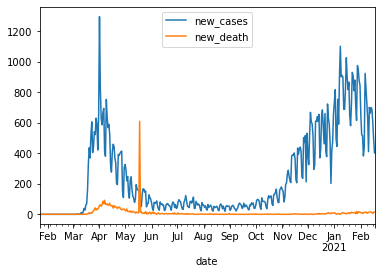

In [30]:
ny = out[out['fips']==36061].set_index('date')[['new_cases', 'new_death']]
ny.plot()

In addition, let us extract only the cases of New York City.

* 36005 - Bronx
* 36047 - Brooklyn (Kings)
* 36061 - Manhattan (New York)
* 36081 - Queens
* 36085 - Staten Island (Richmond)

In [31]:
NYC = [36005, 36047, 36061, 36081, 36085]
NYC_df = out[out['fips'].isin(NYC)][['date', 'new_cases', 'new_death']].groupby(['date']).sum()
NYC_df['county'] = 'New York City'
NYC_df = NYC_df[['county', 'new_cases', 'new_death']]
NYC_df_raw = out_raw[out_raw['fips'].isin(NYC)][['date', 'new_cases', 'new_death']].groupby(['date']).sum()
NYC_df_raw['county'] = 'New York City'
NYC_df_raw = NYC_df_raw[['county', 'new_cases', 'new_death']]
NYC_df
# NYC_df_raw.to_csv('JH_NYC_raw_std.csv', index=False)
# NYC_df.to_csv('JH_NYC_std.csv', index=False)

,county,new_cases,new_death
date,,,
2020-01-22,New York City,0.0,0.0
2020-01-23,New York City,0.0,0.0
2020-01-24,New York City,0.0,0.0
2020-01-25,New York City,0.0,0.0
2020-01-26,New York City,0.0,0.0
...,...,...,...
2021-02-13,New York City,4573.0,77.0
2021-02-14,New York City,4132.0,97.0
2021-02-15,New York City,3625.0,66.0


In [32]:
# disaggregated New York City
dNYC_df = out[out['fips'].isin(NYC)]
dNYC_df_raw = out_raw[out_raw['fips'].isin(NYC)]
dNYC_df = dNYC_df[['fips', 'date', 'county', 'new_cases', 'new_death']]
dNYC_df_raw = dNYC_df_raw[['fips', 'date', 'county', 'new_cases', 'new_death']]
dNYC_df
# dNYC_df.to_csv('JH_disaggregated_NYC_raw_std.csv', index=False)
# dNYC_df_raw.to_csv('JH_disaggregated_NYC_std.csv', index=False)

,fips,date,county,new_cases,new_death
1838,36005.0,2020-01-22,Bronx,0.0,0.0
1859,36047.0,2020-01-22,Kings,0.0,0.0
1866,36061.0,2020-01-22,New York,0.0,0.0
1876,36081.0,2020-01-22,Queens,0.0,0.0
1878,36085.0,2020-01-22,Richmond,0.0,0.0
...,...,...,...,...,...
1270350,36005.0,2021-02-17,Bronx,607.0,7.0
1270371,36047.0,2021-02-17,Kings,894.0,25.0
1270378,36061.0,2021-02-17,New York,403.0,15.0
1270388,36081.0,2021-02-17,Queens,829.0,22.0


In [33]:
from IPython.display import HTML
gj = 'https://media1.tenor.com/images/4160d3e885c0d707ad6d72217c487dc3/tenor.gif?itemid=10828968'
HTML(f'<img src="{gj}">')